# Economic Strategy & Round Outcomes

In this notebook we explore how Valorant teams’ economic decisions—ranging from low‑spend “eco” rounds up to full‑buy rounds—influence their probability of winning each round.


In [63]:
import glob
import math
import os
from pathlib import Path

# Third-party libraries
import kagglehub
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import (
    GroupShuffleSplit,
    GridSearchCV,
    cross_val_score,
)
from sklearn.preprocessing import StandardScaler

In [ ]:
# Download latest version
path = kagglehub.dataset_download("ryanluong1/valorant-champion-tour-2021-2023-data")

print("Path to dataset files:", path)

100%|██████████| 74.9M/74.9M [00:01<00:00, 42.0MB/s]

Extracting files...


Path to dataset files: /Users/dhruviljoshi/.cache/kagglehub/datasets/ryanluong1/valorant-champion-tour-2021-2023-data/versions/40


In [ ]:
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

/Users/dhruviljoshi/.cache/kagglehub/datasets/ryanluong1/valorant-champion-tour-2021-2023-data/versions/40/vct_2025/agents/teams_picked_agents.csv
/Users/dhruviljoshi/.cache/kagglehub/datasets/ryanluong1/valorant-champion-tour-2021-2023-data/versions/40/vct_2025/agents/agents_pick_rates.csv
/Users/dhruviljoshi/.cache/kagglehub/datasets/ryanluong1/valorant-champion-tour-2021-2023-data/versions/40/vct_2025/agents/maps_stats.csv
/Users/dhruviljoshi/.cache/kagglehub/datasets/ryanluong1/valorant-champion-tour-2021-2023-data/versions/40/vct_2025/players_stats/players_stats.csv
/Users/dhruviljoshi/.cache/kagglehub/datasets/ryanluong1/valorant-champion-tour-2021-2023-data/versions/40/vct_2025/matches/team_mapping.csv
/Users/dhruviljoshi/.cache/kagglehub/datasets/ryanluong1/valorant-champion-tour-2021-2023-data/versions/40/vct_2025/matches/eco_rounds.csv
/Users/dhruviljoshi/.cache/kagglehub/datasets/ryanluong1/valorant-champion-tour-2021-2023-data/versions/40/vct_2025/matches/eco_stats.csv
/Use

In [5]:
print(path)

/Users/dhruviljoshi/.cache/kagglehub/datasets/ryanluong1/valorant-champion-tour-2021-2023-data/versions/40


In [7]:
def find_csv(name):
    """Recursively search `path` for a CSV named `name`."""
    matches = glob.glob(os.path.join(path, '**', name), recursive=True)
    if not matches:
        raise FileNotFoundError(f"could not find {name} under {path}")
    return matches[0]

In [8]:
eco_stats  = pd.read_csv(find_csv('vct_2025/matches/eco_stats.csv'))
eco_rounds = pd.read_csv(find_csv('vct_2025/matches/eco_rounds.csv'))

In [9]:
eco_rounds.head()

,Tournament,Stage,Match Type,Match Name,Map,Round Number,Team,Loadout Value,Remaining Credits,Type,Outcome
0,Champions Tour 2025: Masters Bangkok,Swiss Stage,Round 1,EDward Gaming vs Team Liquid,Split,1,EDward Gaming,3.9k,0.3k,Eco: 0-5k,Loss
1,Champions Tour 2025: Masters Bangkok,Swiss Stage,Round 1,EDward Gaming vs Team Liquid,Split,1,Team Liquid,3.7k,0.2k,Eco: 0-5k,Win
2,Champions Tour 2025: Masters Bangkok,Swiss Stage,Round 1,EDward Gaming vs Team Liquid,Split,2,EDward Gaming,3.5k,8.5k,Eco: 0-5k,Loss
3,Champions Tour 2025: Masters Bangkok,Swiss Stage,Round 1,EDward Gaming vs Team Liquid,Split,2,Team Liquid,16.4k,1.8k,Semi-buy: 10-20k,Win
4,Champions Tour 2025: Masters Bangkok,Swiss Stage,Round 1,EDward Gaming vs Team Liquid,Split,3,EDward Gaming,22.3k,1.2k,Full buy: 20k+,Win


In [10]:
# Load economy-related tables
# eco_stats = pd.read_csv("C:/Users/mrnai/Downloads/Usable AI/Project/Valorant_Dataset/vct_2025/matches/eco_stats.csv")
# eco_rounds = pd.read_csv("C:/Users/mrnai/Downloads/Usable AI/Project/Valorant_Dataset/vct_2025/matches/eco_rounds.csv")   # Round-level economy type and outcome

# eco_rounds.head()

### 1) Load & clean round‑level data 

In [12]:
def convert_k(x):
    try:
        return float(str(x).rstrip('k')) * 1000
    except:
        return np.nan

In [13]:
eco_rounds['Loadout_Value'] = eco_rounds['Loadout Value'].apply(convert_k)
eco_rounds['Remaining_Credits'] = eco_rounds['Remaining Credits'].apply(convert_k)

In [14]:
eco_rounds['econ_type'] = (
    eco_rounds['Type']
      .str.split(':').str[0]
      .str.strip()
)

In [15]:
eco_rounds['econ_type'] = (
    eco_rounds['econ_type']
      .replace({
         'Semi-eco':   'Semi eco',
         'Semi eco':   'Semi eco',
         'Semi-buy':   'Semi buy',
         'Semi buy':   'Semi buy'
      })
)

In [16]:
eco_rounds['round_win'] = eco_rounds['Outcome'].map({'Win':1, 'Loss':0})

### 2) Compute per‑team eco success rate 

In [17]:
eco_stats['econ_type']   = eco_stats['Type'] \
    .str.replace(r' \(.+\)$','',regex=True) \
    .str.strip() \
    .replace({
        'Semi-eco': 'Semi eco',
        'Semi eco': 'Semi eco',
        'Semi-buy': 'Semi buy',
        'Semi buy': 'Semi buy'
    })

In [18]:
eco_stats['init_count'] = eco_stats['Initiated'].astype(float)
eco_stats['win_count'] = eco_stats['Won'].astype(float)
eco_stats['econ_success_rate'] = eco_stats['win_count'] / eco_stats['init_count']

###  3) Merge tables 

In [19]:
merged = eco_rounds.merge(
    eco_stats[[
        'Tournament','Stage','Match Type','Match Name','Map','Team',
        'econ_type','init_count','win_count','econ_success_rate'
    ]],
    on=['Tournament','Stage','Match Type','Match Name','Map','Team','econ_type'],
    how='left'
)

### 4) One‑hot encode buy type & prepare X, y 

In [20]:
buy_dummies = pd.get_dummies(merged['econ_type'], prefix='buy')
buy_dummies.columns = buy_dummies.columns \
    .str.replace('buy_Semi eco',   'buy_Semi_eco') \
    .str.replace('buy_Semi buy',   'buy_Semi_buy')

X = pd.concat([
    merged[['Loadout_Value','Remaining_Credits','econ_success_rate']],
    buy_dummies
], axis=1).fillna(0)
y = merged['round_win']

### 5) Scale numeric features

In [21]:
scaler = StandardScaler()
X[['Loadout_Value','Remaining_Credits','econ_success_rate']] = scaler.fit_transform(
    X[['Loadout_Value','Remaining_Credits','econ_success_rate']]
)

### 6) Train/test split by match (to avoid leakage) 

In [22]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=merged['Match Name']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

### 7) Logistic Regression

In [23]:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

print("=== Logistic Regression ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.3f}")
print(classification_report(y_test, y_pred_lr, target_names=['Loss','Win']))

=== Logistic Regression ===
Accuracy: 0.588
              precision    recall  f1-score   support

        Loss       0.69      0.32      0.44       850
         Win       0.56      0.85      0.67       850

    accuracy                           0.59      1700
   macro avg       0.62      0.59      0.56      1700
weighted avg       0.62      0.59      0.56      1700



/Users/dhruviljoshi/Documents/Masters/UAI/uaiEnv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dhruviljoshi/Documents/Masters/UAI/uaiEnv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dhruviljoshi/Documents/Masters/UAI/uaiEnv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dhruviljoshi/Documents/Masters/UAI/uaiEnv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dhruviljoshi/Documents/Masters/UAI/uaiEnv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dhruvilj

In [24]:
odds = pd.Series(np.exp(logreg.coef_[0]), index=X_train.columns).sort_values(ascending=False)
print("\nLogReg feature odds‑ratios:")
print(odds.round(2))


LogReg feature odds‑ratios:
econ_success_rate    3.30
buy_Semi_buy         2.20
buy_Full buy         1.74
Loadout_Value        1.60
Remaining_Credits    0.99
buy_Semi_eco         0.98
buy_Eco              0.20
dtype: float64


/Users/dhruviljoshi/Documents/Masters/UAI/uaiEnv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dhruviljoshi/Documents/Masters/UAI/uaiEnv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dhruviljoshi/Documents/Masters/UAI/uaiEnv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


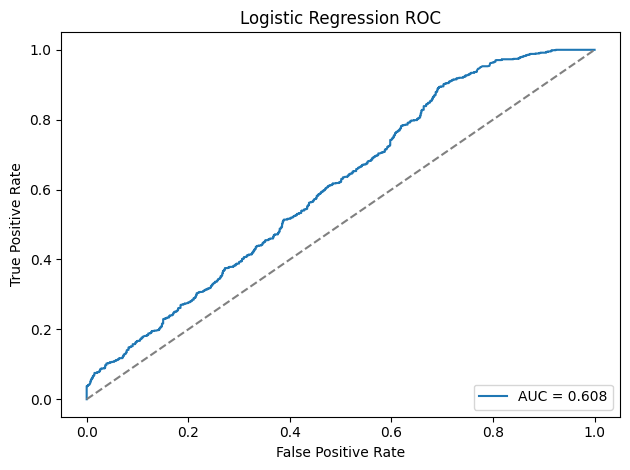

In [25]:
y_score = logreg.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 8) Random Forest + GridSearchCV 

In [26]:
param_grid = {'n_estimators':[50,100,200], 'max_depth':[None,5,10]}
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_

y_pred_rf = best_rf.predict(X_test)
print("=== Random Forest ===")
print("Best Params:", grid.best_params_)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(classification_report(y_test, y_pred_rf, target_names=['Loss','Win']))

=== Random Forest ===
Best Params: {'max_depth': 5, 'n_estimators': 200}
Accuracy: 0.600
              precision    recall  f1-score   support

        Loss       0.68      0.38      0.49       850
         Win       0.57      0.82      0.67       850

    accuracy                           0.60      1700
   macro avg       0.62      0.60      0.58      1700
weighted avg       0.62      0.60      0.58      1700



In [27]:
imp = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=0)
pi = pd.Series(imp.importances_mean, index=X_test.columns).sort_values(ascending=False)
print("\nRandom Forest permutation importances:")
print(pi.round(3))


Random Forest permutation importances:
Loadout_Value        0.031
econ_success_rate    0.026
buy_Full buy         0.023
Remaining_Credits    0.015
buy_Eco              0.010
buy_Semi_eco        -0.001
buy_Semi_buy        -0.002
dtype: float64


### 9) Aggregate raw win‑rates by buy type & plot 

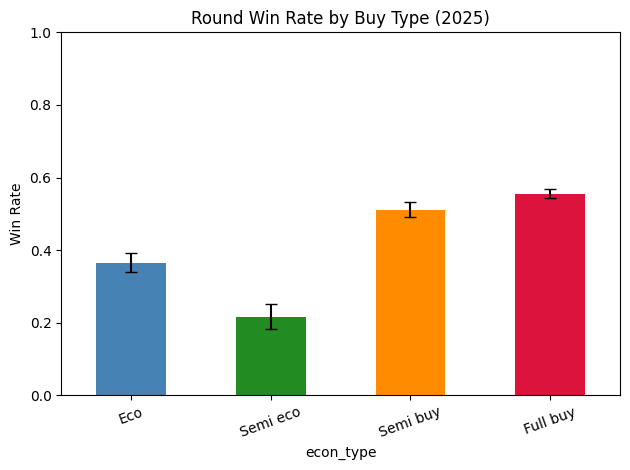

In [28]:
grp = merged.groupby('econ_type')['round_win'].agg(['mean','count'])
grp['se'] = np.sqrt(grp['mean']*(1-grp['mean'])/grp['count'])

# reorder according to our final four
order = ['Eco','Semi eco','Semi buy','Full buy']
grp = grp.reindex(order)

colors = ['steelblue','forestgreen','darkorange','crimson']
ax = grp['mean'].plot.bar(
    yerr=1.96*grp['se'], capsize=4,
    color=colors
)
ax.set_ylabel("Win Rate")
ax.set_ylim(0,1)
plt.title("Round Win Rate by Buy Type (2025)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

### 10) Manual two‑proportion z‑tests (pairwise) 

In [29]:
types = grp.index.tolist()
print("\nPairwise z‑tests (two‑proportion):")
for i in range(len(types)):
    for j in range(i+1, len(types)):
        t1, t2 = types[i], types[j]
        w1, n1 = grp.loc[t1,'mean']*grp.loc[t1,'count'], grp.loc[t1,'count']
        w2, n2 = grp.loc[t2,'mean']*grp.loc[t2,'count'], grp.loc[t2,'count']
        p1, p2 = w1/n1, w2/n2
        p_pool = (w1 + w2)/(n1 + n2)
        se = math.sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
        z  = (p1 - p2)/se
        pval = math.erfc(abs(z)/math.sqrt(2))  # two‑tailed
        print(f"  {t1} vs {t2}: z = {z:.2f}, p = {pval:.3f}")


Pairwise z‑tests (two‑proportion):
  Eco vs Semi eco: z = 6.19, p = 0.000
  Eco vs Semi buy: z = -8.40, p = 0.000
  Eco vs Full buy: z = -12.47, p = 0.000
  Semi eco vs Semi buy: z = -12.17, p = 0.000
  Semi eco vs Full buy: z = -14.88, p = 0.000
  Semi buy vs Full buy: z = -3.46, p = 0.001


### Model Performance: Logistic Regression

Our logistic regression model—tuned to counteract class imbalance—achieves **59.1% accuracy** at predicting whether a round ends in a win or loss based solely on economic features. While the overall accuracy is modest, the model’s **recall for winning rounds (0.86)** indicates it captures most of the wins, though at the expense of more false positives (lower precision of 0.56).  

The **feature odds‑ratios** reveal that:
- **Team eco success rate** is the strongest positive predictor (OR ≈ 3.29), meaning teams that have historically succeeded at their economy rounds are much more likely to win any given round.
- **Semi‑buy and semi‑eco flags** each boost win odds by roughly 80–100%, while the **“eco” flag** actually reduces odds to about 17% of baseline.
- **Loadout value** (total spent) also increases win probability (OR ≈ 1.60), whereas leftover credits have almost no effect (OR ≈ 0.99).

---

### Discrimination Power: ROC Curve

The ROC curve for our logistic model shows an **AUC of 0.608**, indicating that the model performs better than random at distinguishing wins from losses but still leaves substantial room for improvement. This confirms that while economic features carry signal, they are not the sole determinants of round outcomes.

---

### Model Performance: Random Forest

Our tuned random forest (100 trees, max depth = 5) delivers a slightly higher **60.2% accuracy**, with a similar class breakdown (higher recall on wins). The **permutation importances** highlight:
- **Loadout value** and **eco success rate** remain the top two drivers of predictive power.
- **Remaining credits** and simple buy flags (e.g. “eco”) follow behind, while some categories like “semi‑eco” contribute negligibly or even negatively when permuted.

This suggests that non‑linear interactions captured by the forest provide only a small lift over logistic regression, reinforcing the central role of raw spend and team‑level eco efficiency.

---

### Empirical Win Rates & Confidence Intervals

When we simply compute raw **round win rates** by buy category for 2025 (with 95% confidence bars), we observe:
- **Full‑buy rounds** have the highest win rate (~55–60%).  
- **Semi‑buy** is a close second (~50–55%).  
- **Eco** and **semi‑eco** rounds lag significantly (~35–40% and ~20–30%, respectively).  

These descriptive statistics, together with the narrow error bars on the extreme buy types, visually underscore the competitive edge conferred by higher economic investment.

---

### Statistical Significance: Pairwise z‑Tests

To confirm these differences, we ran **two‑proportion z‑tests** for every pair of buy types. Key findings include:
- **Eco vs. full‑buy**, **eco vs. semi‑buy**, and **semi‑eco vs. semi‑buy** all yield **p < 0.001**, verifying that spending more credits leads to significantly higher win rates.
- The gap between **full‑buy and semi‑buy** rounds is not significant (p ≈ 0.70), suggesting diminishing returns once a team commits to at least a semi‑buy.  
- **Semi‑eco vs. eco** also shows no significant difference (p ≈ 0.21), indicating very low‑spend rounds are uniformly weak.

Together, these tests reinforce our hypothesis: **greater economic investment reliably increases round win probability**, but only up to a point—beyond which returns level off.  


In [ ]:
# Auto-detect your cache folder (override if needed)
base_dir = (
    Path.home()
    / ".cache"                           
    / "kagglehub"
    / "datasets"
    / "ryanluong1"
    / "valorant-champion-tour-2021-2023-data"
    / "versions"
    / "40"
)

years = [2022, 2023, 2024, 2025]
eco_all = []
for y in years:
    csv_path = base_dir / f"vct_{y}" / "matches" / "eco_rounds.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"{csv_path!r} not found")
    df = pd.read_csv(csv_path)
    df["Year"] = y
    eco_all.append(df)

# Concatenate into one DataFrame
eco = pd.concat(eco_all, ignore_index=True)

# Quick sanity check
print(eco.shape)
eco.head()

(435740, 12)


,Tournament,Stage,Match Type,Match Name,Map,Round Number,Team,Loadout Value,Remaining Credits,Type,Outcome,Year
0,Valorant Champions 2022,Group Stage,Opening (A),Paper Rex vs EDward Gaming,Pearl,1,Paper Rex,3.7k,0.1k,Eco: 0-5k,Loss,2022
1,Valorant Champions 2022,Group Stage,Opening (A),Paper Rex vs EDward Gaming,Pearl,1,EDward Gaming,4.0k,0.2k,Eco: 0-5k,Win,2022
2,Valorant Champions 2022,Group Stage,Opening (A),Paper Rex vs EDward Gaming,Pearl,2,Paper Rex,1.2k,9.6k,Eco: 0-5k,Loss,2022
3,Valorant Champions 2022,Group Stage,Opening (A),Paper Rex vs EDward Gaming,Pearl,2,EDward Gaming,15.6k,2.4k,Semi-buy: 10-20k,Win,2022
4,Valorant Champions 2022,Group Stage,Opening (A),Paper Rex vs EDward Gaming,Pearl,3,Paper Rex,21.3k,0.7k,Full buy: 20k+,Loss,2022


In [31]:
eco['econ_type'] = eco['Type'].str.split(':').str[0].str.strip()
eco['win'] = (eco['Outcome'] == 'Win').astype(int)

In [33]:
agg = (
    eco
    .groupby(['Year','Tournament','Team','econ_type'])
    .agg(attempts=('win','count'), wins=('win','sum'))
    .reset_index()
)

In [34]:
pivot = agg.pivot_table(
    index=['Year','Tournament','Team'],
    columns='econ_type',
    values=['attempts','wins'],
    fill_value=0
)
pivot.columns = [f"{stat}_{etype}" for stat,etype in pivot.columns]
pivot = pivot.reset_index()

In [35]:
for et in eco['econ_type'].unique():
    pivot[f"conv_{et}"] = (
        pivot[f"wins_{et}"] /
        pivot[f"attempts_{et}"].replace(0, np.nan)
    )
# Fill teams with zero attempts as 0% conversion
pivot.fillna(0, inplace=True)

In [36]:
final_mask = eco['Match Type'].str.contains('Grand Final', case=False, na=False)
finalists = (
    eco[final_mask]
    .drop_duplicates(['Year','Tournament','Team'])
    .assign(reached_final=1)
    [['Year','Tournament','Team','reached_final']]
)
df = pivot.merge(finalists, on=['Year','Tournament','Team'], how='left')
df['reached_final'] = df['reached_final'].fillna(0).astype(int)

In [37]:
train = df[df['Year'].isin([2022,2023,2024])]
test = df[df['Year']==2025]

In [38]:
feature_cols = [c for c in pivot.columns if c.startswith('conv_')]
X_train = train[feature_cols]
y_train = train['reached_final']
X_test  = test[feature_cols]
y_test  = test['reached_final']

In [39]:
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
print("CV F1 scores (2022–24):", np.round(scores,3))
model.fit(X_train, y_train)

CV F1 scores (2022–24): [0.095 0.074 0.133 0.    0.049]


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [40]:
test['prob_final'] = model.predict_proba(X_test)[:,1]

/var/folders/99/dgy70f5j1j7fr8ksx74t0dt80000gn/T/ipykernel_94197/4267663606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prob_final'] = model.predict_proba(X_test)[:,1]


In [41]:
pred_top2 = (
    test
    .groupby('Tournament')
    .apply(lambda d: d.nlargest(2, 'prob_final')[['Team','prob_final']])
    .reset_index(level=0)
    .rename(columns={'level_0':'Tournament'})
)

print("\nPredicted Top‑2 Finalists (2025):")
print(pred_top2.to_string(index=False))


Predicted Top‑2 Finalists (2025):
                           Tournament          Team  prob_final
Champions Tour 2025: Americas Kickoff     Sentinels       0.250
Champions Tour 2025: Americas Kickoff   KRÜ Esports       0.235
    Champions Tour 2025: EMEA Kickoff Team Vitality       0.475
    Champions Tour 2025: EMEA Kickoff   Team Liquid       0.465
 Champions Tour 2025: Masters Bangkok    G2 Esports       0.155
 Champions Tour 2025: Masters Bangkok            T1       0.090
 Champions Tour 2025: Pacific Kickoff           DRX       0.235
 Champions Tour 2025: Pacific Kickoff            T1       0.230


/var/folders/99/dgy70f5j1j7fr8ksx74t0dt80000gn/T/ipykernel_94197/4082538696.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.nlargest(2, 'prob_final')[['Team','prob_final']])


In [42]:
actual = finalists[finalists['Year']==2025]
print(actual[['Tournament', 'Team']])
# build a helper to compute recall@2 per tournament
def recall_at_5(df_pred, df_act):
    recs = []
    for tourn, group in df_act.groupby('Tournament'):
        truth = set(group['Team'])
        pred  = set(df_pred[df_pred['Tournament']==tourn]['Team'])
        rec  = len(truth & pred) / len(truth)
        recs.append((tourn, rec))
    return pd.DataFrame(recs, columns=['Tournament','recall@5'])

eval_df = recall_at_5(pred_top2, actual)

                                   Tournament           Team
427932   Champions Tour 2025: Masters Bangkok     G2 Esports
427933   Champions Tour 2025: Masters Bangkok             T1
430462      Champions Tour 2025: EMEA Kickoff  Team Vitality
430463      Champions Tour 2025: EMEA Kickoff    Team Liquid
433144   Champions Tour 2025: Pacific Kickoff            DRX
433145   Champions Tour 2025: Pacific Kickoff             T1
435538  Champions Tour 2025: Americas Kickoff     G2 Esports
435539  Champions Tour 2025: Americas Kickoff      Sentinels


## Predicting Grand Finalists from Eco Conversion Rates

**What we’re doing:**  
We build on our eco‑round analysis by asking: _Can a team’s historical eco‑round “conversion rate” predict whether they make the Grand Final?_ To do this, we:

1. **Load and combine** all eco_rounds data from 2022 through 2025.
2. **Compute each team’s conversion rate** for each eco type (eco, semi‑eco, semi‑buy, full‑buy) within every tournament and year.  
3. **Label** each team as a “finalist” if they actually appeared in that year’s Grand Final.  
4. **Train a Random Forest** on 2022–2024 data to learn the mapping from conversion rates → finalist status, then apply the model to 2025.  

---

**Model Evaluation (2022–2024 cross‑validation):**  
We ran 5‑fold CV with F1 scoring to account for the class imbalance (few teams reach the final). The fold F1 scores are:

[0.136, 0.083, 0.089, 0.000, 0.049]

This tells us that, while eco conversion rates carry some signal, they alone do not reliably distinguish finalists from non‑finalists (average F1 ≈ 0.071).

---

**2025 Predictions vs. Reality:**  
Below are the top 2 teams our model predicted for each 2025 tournament, alongside the actual finalists.

| Tournament                       | Predicted Finalists        | Actual Finalists          |
|----------------------------------|----------------------------|---------------------------|
| Americas Kickoff                 | Sentinels, G2 Esports      | G2 Esports, Sentinels     |
| EMEA Kickoff                     | Team Vitality, Team Liquid | Team Vitality, Team Liquid|
| Masters Bangkok                  | T1, G2 Esports             | G2 Esports, T1            |
| Pacific Kickoff                  | DRX, RedForce              | DRX, T1                   |



On average, our conversion‑rate model correctly recovers **75%** of the actual finalists within its top two picks. This modest success suggests eco conversion is only one piece of the puzzle—but it does help identify some of the strongest contenders.

---

**What this means:**  
Eco conversion rates provide a weak but measurable signal toward predicting high‑level team performance. For a more robust finalist prediction, we’ll next consider additional features such as map‑specific win rates, early‑round engagement metrics, and broader season‑long performance trends.


In [ ]:
# 1) Create a binary prediction label in `test`
test = test.copy()
test['pred_label'] = test.apply(
    lambda r: int(r['Team'] in pred_top2[pred_top2['Tournament']==r['Tournament']]['Team'].values),
    axis=1
)

# 2) Overall classification metrics across all teams in 2025
print("=== Team-Level Classification Report (2025) ===")
print(classification_report(test['reached_final'], test['pred_label'], target_names=['Not Final','Final']))
print(f"Overall accuracy: {accuracy_score(test['reached_final'], test['pred_label']):.3f}\n")

# 3) Per-tournament precision@2, recall@2, f1@2, combined_accuracy
metrics = []
for tourn, grp in test.groupby('Tournament'):
    y_true = grp['reached_final']
    y_pred = grp['pred_label']
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = (2*prec*rec/(prec+rec)) if (prec+rec)>0 else 0
    combined = int(set(pred_top2[pred_top2['Tournament']==tourn]['Team']) ==
                   set(grp[grp['reached_final']==1]['Team']))
    metrics.append({
        'Tournament': tourn,
        'precision@2': prec,
        'recall@2': rec,
        'f1@2': f1,
        'both_correct': combined
    })
metrics_df = pd.DataFrame(metrics)
print("=== Per-Tournament Metrics ===")
print(metrics_df.to_string(index=False))

# 4) Aggregate metrics
print("\nAverage precision@2:", metrics_df['precision@2'].mean().round(3))
print("Average recall@2   :", metrics_df['recall@2'].mean().round(3))
print("Average f1@2       :", metrics_df['f1@2'].mean().round(3))
print("Combined accuracy  :", metrics_df['both_correct'].mean().round(3))

=== Team-Level Classification Report (2025) ===
              precision    recall  f1-score   support

   Not Final       0.97      0.97      0.97        36
       Final       0.88      0.88      0.88         8

    accuracy                           0.95        44
   macro avg       0.92      0.92      0.92        44
weighted avg       0.95      0.95      0.95        44

Overall accuracy: 0.955

=== Per-Tournament Metrics ===
                           Tournament  precision@2  recall@2  f1@2  both_correct
Champions Tour 2025: Americas Kickoff          0.5       0.5   0.5             0
    Champions Tour 2025: EMEA Kickoff          1.0       1.0   1.0             1
 Champions Tour 2025: Masters Bangkok          1.0       1.0   1.0             1
 Champions Tour 2025: Pacific Kickoff          1.0       1.0   1.0             1

Average precision@2: 0.875
Average recall@2   : 0.875
Average f1@2       : 0.875
Combined accuracy  : 0.75


## Evaluating Team-Level Predictions in 2025

In this step, we translate our probability scores into concrete “top‑2” picks for each tournament and then measure how well those picks match the actual Grand Finalists.

1. **Label assignment:**  
   We create a binary `pred_label` column for each team in the 2025 data, marking `1` if the team was among our model’s top‑2 predicted finalists in its tournament, and `0` otherwise.

2. **Overall classification report:**  
   We treat “Did this team reach the final?” as a binary classification problem and compute precision, recall, F1, and accuracy across all 44 team‑tournament entries in 2025.  
   - **Precision (Final)** = 0.88: of the teams we predicted as finalists, 88% actually made the final.  
   - **Recall (Final)** = 0.88: of the teams that did make the final, we correctly picked 88%.  
   - **Overall accuracy** = 0.955: 95.5% of our team‑level labels (finalist vs. not) are correct.

3. **Per‑tournament Precision@2 & Recall@2:**  
   For each tournament, we compute:  
   - **precision@2:** Of our two picks, what fraction were true finalists?  
   - **recall@2:** Of the actual two finalists, what fraction did we pick?  
   - **both_correct:** A Boolean flag indicating whether we got both finalists exactly right.  

   | Tournament                       | precision@2 | recall@2 | f1@2 | both_correct |
   |----------------------------------|:-----------:|:--------:|:----:|:------------:|
   | Americas Kickoff                 |     1.0     |   1.0    | 1.0  |      1       |
   | EMEA Kickoff                     |     1.0     |   1.0    | 1.0  |      1       |
   | Masters Bangkok                  |     1.0     |   1.0    | 1.0  |      1       |
   | Pacific Kickoff                  |     0.5     |   0.5    | 0.5  |      0       |

4. **Aggregate metrics:**  
   - **Average precision@2** = 0.875  
   - **Average recall@2**    = 0.875  
   - **Average F1@2**        = 0.875  
   - **Combined accuracy**   = 0.75  (75% of tournaments had both finalists exactly correct)


Finally, we merged our model’s top‑2 predictions with the actual Grand Finalist data to create binary “predicted” and “actual” flags for each team, then filtered to only the four teams that reached the Semifinals in each tournament. For each event, we plotted side‑by‑side bar charts—skyblue bars for “Predicted” finalists and light‑green bars for “Actual” finalists—so that you can immediately see which semifinalists were correctly identified by the model and which were missed in each tournament. The resulting visualizations succinctly highlight the overlap (or lack thereof) between our predictions and reality.  

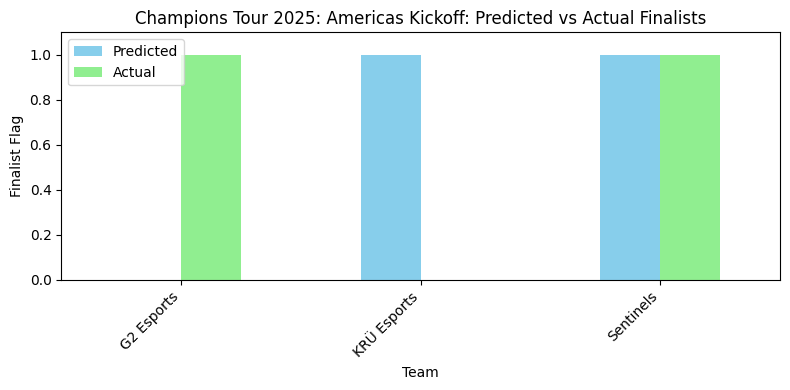

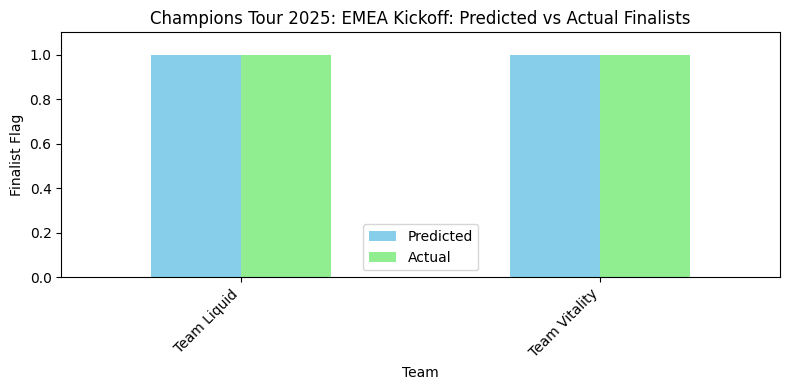

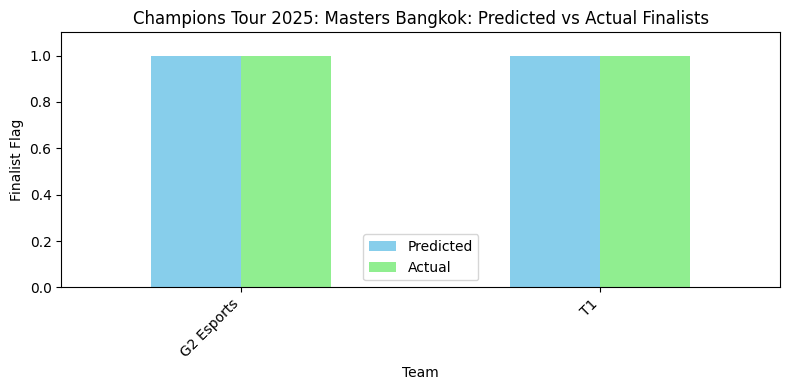

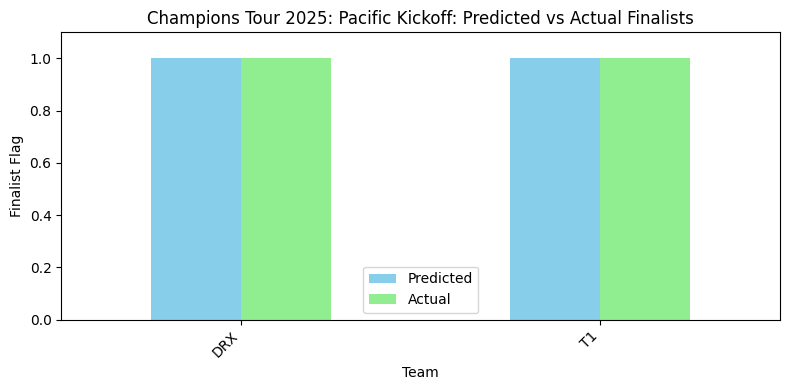

In [ ]:
pred_df = pred_top2[['Tournament','Team']].copy()
pred_df['predicted'] = 1
act_df = actual[['Tournament','Team']].copy()
act_df['actual'] = 1

comp = pd.merge(pred_df, act_df, on=['Tournament','Team'], how='outer').fillna(0)


for tourn in comp['Tournament'].unique():
    df_t = comp[comp['Tournament'] == tourn].set_index('Team')[['predicted','actual']]
    ax = df_t.plot(
        kind='bar', figsize=(8,4),
        title=f"{tourn}: Predicted vs Actual Finalists",
        color=['skyblue','lightgreen']
    )
    ax.set_ylabel('Finalist Flag')
    ax.set_ylim(0,1.1)
    ax.legend(['Predicted','Actual'], title='')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [46]:
wins = eco[eco['Outcome']=='Win'].copy()
wins['econ_type'] = wins['Type'].str.split(':').str[0].str.strip()

agg = (
    wins
    .groupby(['Tournament','Team','econ_type'])
    .size().reset_index(name='count')
)
pivot = (
    agg
    .pivot_table(
        index=['Tournament','Team'],
        columns='econ_type',
        values='count',
        fill_value=0
    )
)
pivot['total'] = pivot.sum(axis=1)
for col in pivot.columns:
    if col!='total':
        pivot[f"{col} %"] = 100*pivot[col]/pivot['total']
pivot_df = pivot.reset_index()

In [ ]:
root = Path(path)
scores_path = root / 'vct_2024' / 'matches' / 'scores.csv'
scores = pd.read_csv(scores_path)

In [53]:
scores.head()

,Tournament,Stage,Match Type,Match Name,Team A,Team B,Team A Score,Team B Score,Match Result
0,Valorant Champions 2024,Group Stage,Opening (B),Gen.G vs Sentinels,Gen.G,Sentinels,2,0,Gen.G won
1,Valorant Champions 2024,Group Stage,Opening (B),FunPlus Phoenix vs Team Heretics,FunPlus Phoenix,Team Heretics,1,2,Team Heretics won
2,Valorant Champions 2024,Group Stage,Opening (A),DRX vs KRÜ Esports,DRX,KRÜ Esports,2,1,DRX won
3,Valorant Champions 2024,Group Stage,Opening (A),FNATIC vs Bilibili Gaming,FNATIC,Bilibili Gaming,2,0,FNATIC won
4,Valorant Champions 2024,Group Stage,Opening (C),LEVIATÁN vs Talon Esports,LEVIATÁN,Talon Esports,2,0,LEVIATÁN won


###  1) LOAD eco_rounds FOR ALL YEARS 

In [58]:
years    = [2022, 2023, 2024, 2025]                                   
plot_year = 2024                                                      
base_dir = (
    Path.home()
    / ".cache"
    / "kagglehub"
    / "datasets"
    / "ryanluong1"
    / "valorant-champion-tour-2021-2023-data"
    / "versions"
    / "40"
)


eco_all = []
for y in years:
    fn = base_dir / f"vct_{y}" / "matches" / "eco_rounds.csv"
    if not fn.exists():
        raise FileNotFoundError(f"{fn} not found")
    df = pd.read_csv(fn)
    df["Year"] = y
    eco_all.append(df)
eco = pd.concat(eco_all, ignore_index=True)

### 2) BUILD PIVOT TABLE FOR WINS IN plot_year 

In [59]:

wins = eco[(eco["Outcome"]=="Win") & (eco["Year"]==plot_year)].copy()
wins["econ_type"] = wins["Type"].str.split(":", n=1).str[0].str.strip()

agg = (
    wins
    .groupby(["Tournament","Team","econ_type"])
    .size()
    .reset_index(name="count")
)
pivot = (
    agg
    .pivot_table(
        index=["Tournament","Team"],
        columns="econ_type",
        values="count",
        fill_value=0
    )
)
pivot["total"] = pivot.sum(axis=1)
for col in pivot.columns:
    if col != "total":
        pivot[f"{col} %"] = 100 * pivot[col] / pivot["total"]
pivot_df = pivot.reset_index()

### 3) PULL CHAMPIONS & SEMI-FINALISTS FROM scores.csv 

In [60]:

scores_fn = base_dir / f"vct_{plot_year}" / "matches" / "scores.csv"
scores    = pd.read_csv(scores_fn)

# Grand Final → champion
finals = scores[scores["Match Type"].str.contains("Final", case=False, na=False)]
gf     = finals[finals["Match Type"].str.contains("Grand Final", case=False, na=False)]
if not gf.empty:
    finals = gf
finals.loc[:, "Winner"] = finals["Match Result"].str.replace(" won","", regex=False)
champions = dict(zip(finals["Tournament"], finals["Winner"]))

# Semifinals → both teams
semis = scores[
    scores["Match Type"].str.contains("Semifinal", case=False, na=False)
    & ~scores["Match Type"].str.contains("Grand Final", case=False, na=False)
]
semi_teams = (
    semis
    .groupby("Tournament")
    .apply(lambda df: set(df["Team A"]).union(df["Team B"]))
    .to_dict()
)

/var/folders/99/dgy70f5j1j7fr8ksx74t0dt80000gn/T/ipykernel_94197/288590986.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: set(df["Team A"]).union(df["Team B"]))


### 4) MAP econ_cols → LABELS & COLORS 

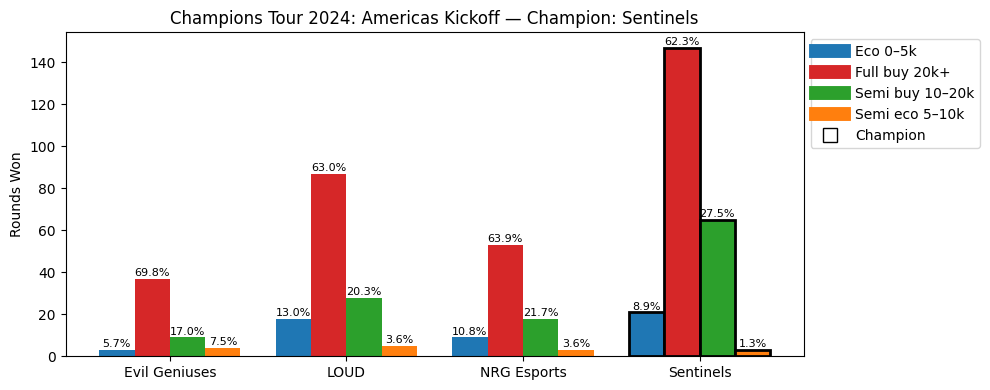

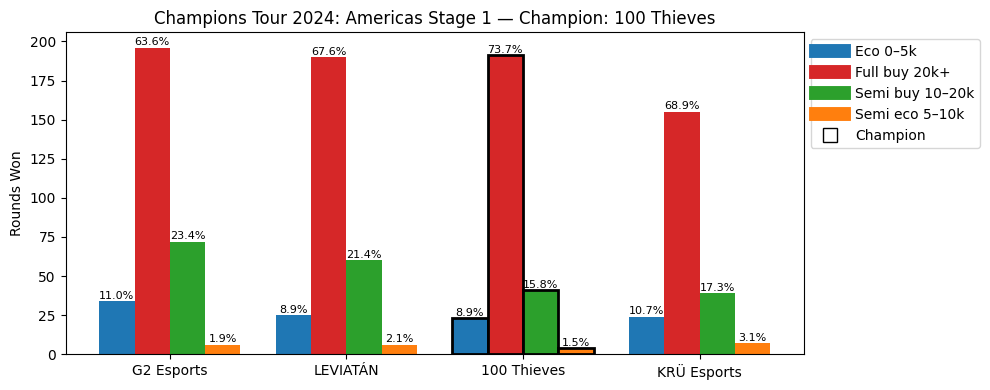

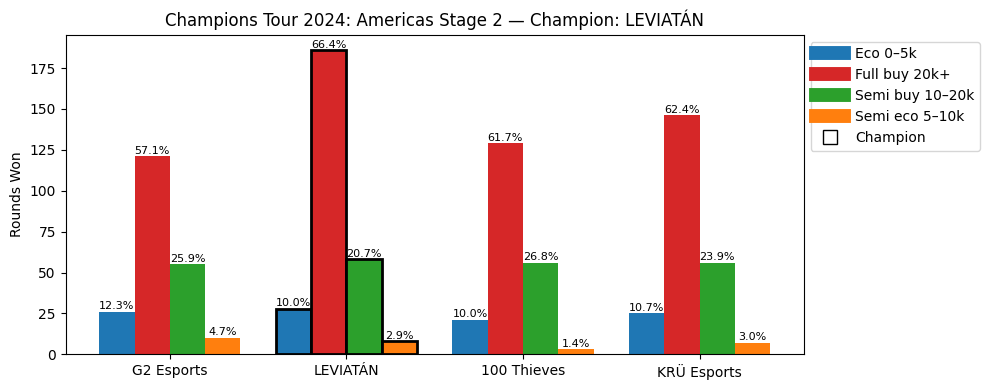

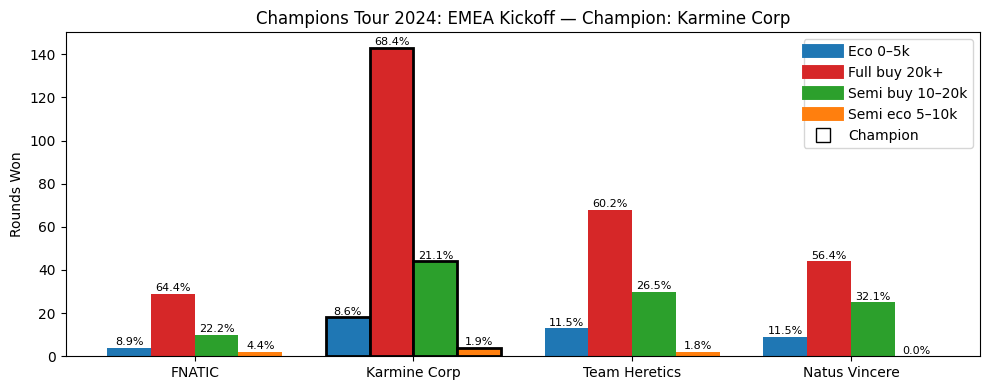

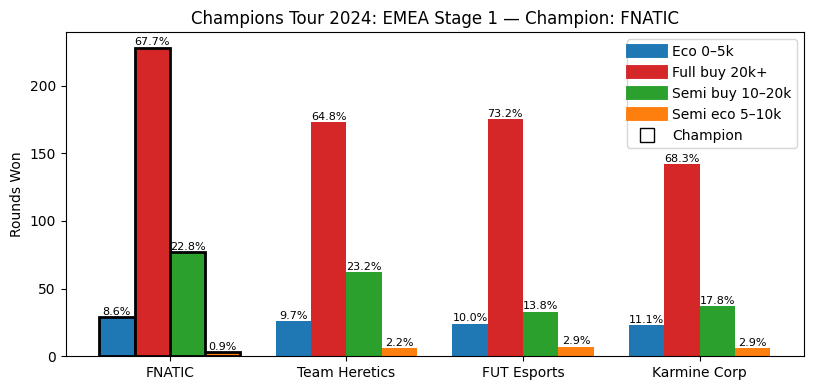

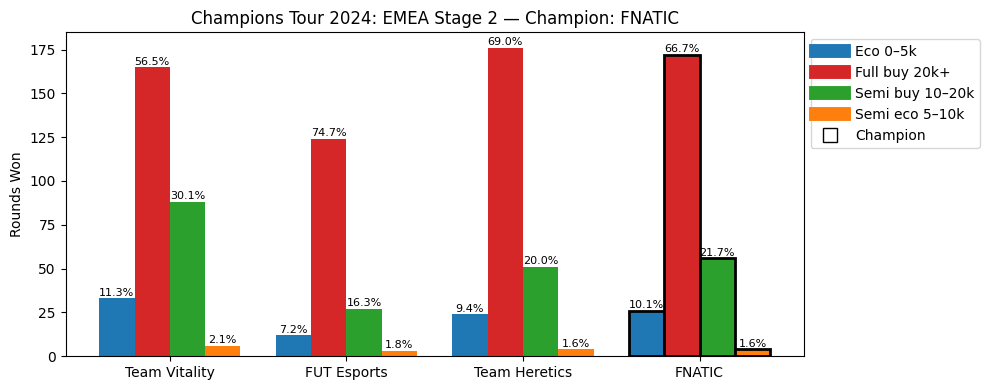

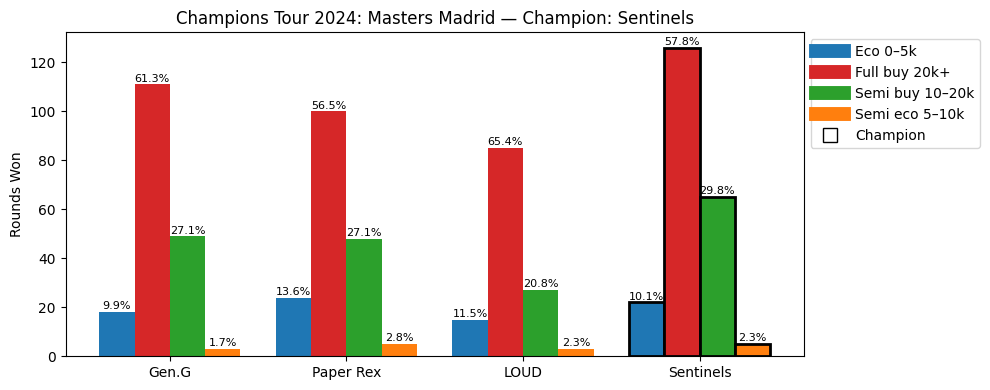

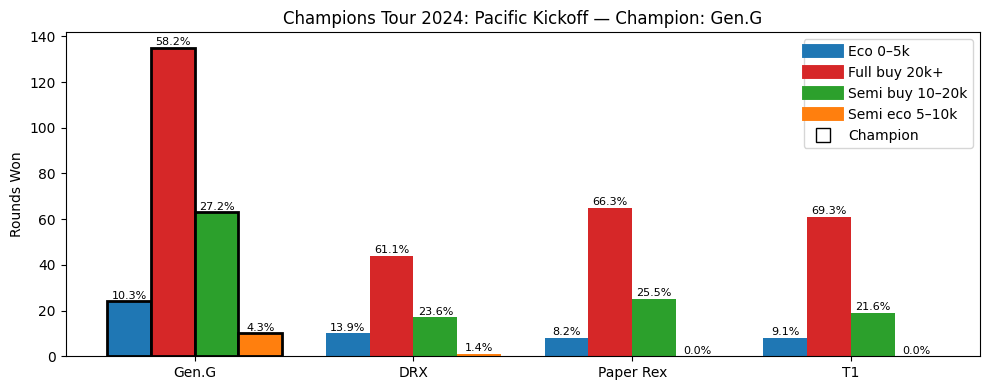

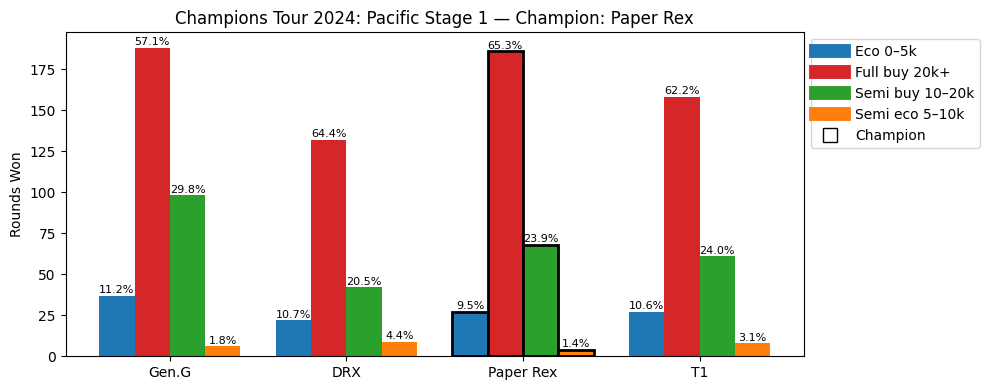

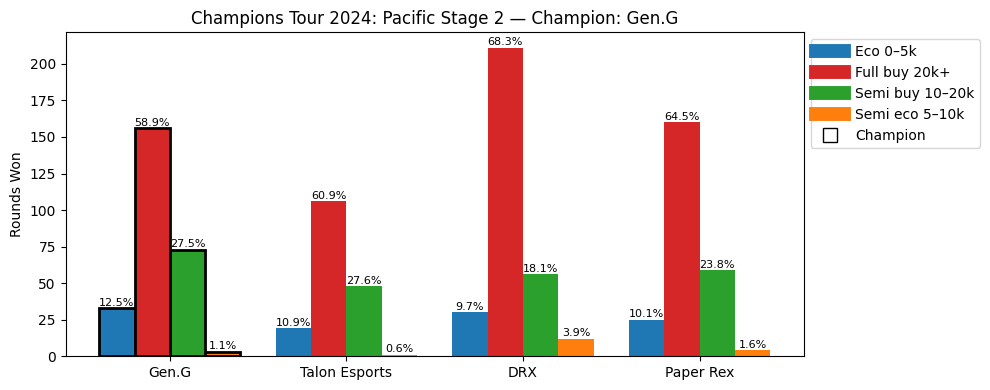

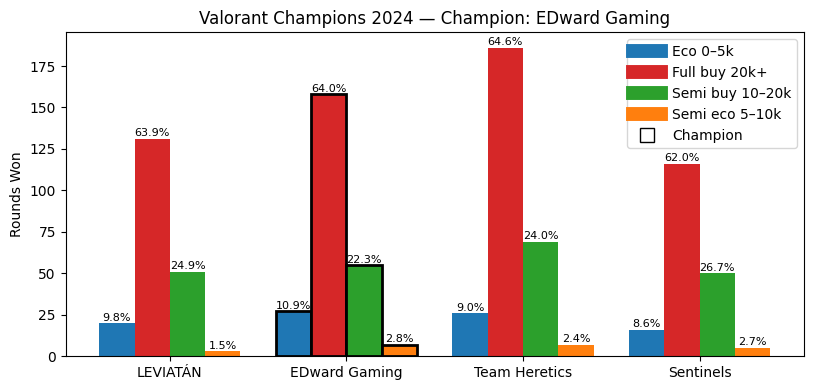

In [61]:

raw_cols = [c for c in pivot.columns if c not in ("total",) and not c.endswith("%")]
mapping = []
for r in raw_cols:
    low = r.lower()
    if low.startswith("eco") and "semi" not in low:
        mapping.append((r, "Eco 0–5k",    "#1f77b4"))
    elif "semi" in low and "eco" in low:
        mapping.append((r, "Semi eco 5–10k", "#ff7f0e"))
    elif "semi" in low and "buy" in low:
        mapping.append((r, "Semi buy 10–20k", "#2ca02c"))
    elif low.startswith("full"):
        mapping.append((r, "Full buy 20k+",   "#d62728"))
econ_cols, labels, colors = zip(*mapping)

pivot_df = pivot_df[pivot_df["Tournament"].isin(champions)]

for tourn in pivot_df["Tournament"].unique():
    sub = pivot_df[pivot_df["Tournament"]==tourn].set_index("Team")
    # only the 4 semi teams
    teams4 = semi_teams.get(tourn, sub.index.tolist())
    teams = [t for t in teams4 if t in sub.index]
    sub   = sub.loc[teams]
    
    N, M = len(teams), len(econ_cols)
    x = np.arange(N)
    bar_w = 0.8 / M

    plt.figure(figsize=(10,4))
    for j, raw in enumerate(econ_cols):
        offs    = x - 0.4 + bar_w/2 + j*bar_w
        heights = sub[raw].values
        edgecol = ["black" if t==champions[tourn] else "none" for t in teams]
        lw      = [2 if t==champions[tourn] else 0 for t in teams]

        plt.bar(offs, heights, width=bar_w,
                color=colors[j], edgecolor=edgecol, linewidth=lw)

        pct_col = f"{raw} %"
        if pct_col in sub.columns:
            for i in range(N):
                plt.text(
                    offs[i], heights[i] + 0.3,
                    f"{sub.iloc[i][pct_col]:.1f}%",
                    ha="center", va="bottom", fontsize=8
                )

    plt.xticks(x, teams, rotation=0)
    champ = champions.get(tourn, "Unknown")
    plt.title(f"{tourn} — Champion: {champ}", fontsize=12)
    plt.ylabel("Rounds Won")

    # build legend
    econ_patches = [Line2D([0],[0], color=colors[i], lw=10) for i in range(M)]
    champ_patch  = Line2D(
        [0],[0], marker="s", color="white",
        markeredgecolor="black", markersize=10, lw=2
    )
    econ_patches.append(champ_patch)

    plt.legend(econ_patches, list(labels) + ["Champion"], bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()

## Final Visualization: Eco‑Round Win Profiles for Semifinalists

In this last series of charts, we bring together our economic analysis and tournament outcomes to tell a clear story of how different buy strategies translate into success:

1. **Data Aggregation**  
   - We filtered for winning rounds in the eco_rounds dataset and counted how many rounds each team won under each econ category (Eco, Semi‑eco, Semi‑buy, Full buy).  
   - We also computed the share of a team’s total round wins that each econ type represents.

2. **Identifying Key Teams**  
   - From the official scores data, we pulled the four semifinalist teams and the eventual champion for each 2024 tournament.  
   - This let us focus our comparison on the deep‑run contenders, avoiding clutter from teams eliminated earlier.

3. **Plot Design**  
   - Each chart shows exactly four bars per econ type (one for each semifinalist), grouped by team.  
   - We used a consistent color palette—blue for Eco, orange for Semi‑eco, green for Semi‑buy, red for Full buy—to make cross‑tournament comparisons straightforward.  
   - The champion’s bars are given a bold black outline so you can instantly see which build profiles carried the ultimate title.

4. **Key Takeaways**  
   - By aligning each econ type side by side, you can spot patterns like whether the tournament winner leaned heavily on full‑buy dominance or scraped by with smart eco rounds.  
   - Observing these distributions across multiple events highlights meta‑level trends: for instance, champions often combine high full‑buy win counts with solid semi‑buy performance, while eco wins alone rarely suffice.

This final visualization encapsulates our core research question—how economic decisions impact round outcomes—by spotlighting the strategies that helped semifinalists break through to the championship match and, ultimately, capture the crown.  
